In [1]:
import pystan
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
model_code = """
data {
  int N; //the number of observations
  int N2; //the size of the new_X matrix
  int K; //the number of columns in the model matrix
  vector[N] y; //the response
  matrix[N,K] X; //the model matrix
  matrix[N2,K] new_X; //the matrix for the predicted values
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
generated quantities {
  vector[N2] y_pred;
  y_pred = new_X*beta; //the y values predicted by the model
}
"""

In [4]:
model_name = 'linear_regression'
pkl_file = model_name + '.pkl'

if os.path.isfile(pkl_file):
    # Reuse previously compiled model
    sm = pickle.load(open(pkl_file, 'rb'))
else:
    # Compile and sample model
    sm = pystan.StanModel(model_code=model_code, model_name=model_name)
    with open(pkl_file, 'wb') as f:
        pickle.dump(sm, f)

In [5]:
# Test data
N = 20
beta = np.array([0.2, 1]).reshape((-1,1))
x = np.linspace(0, 1, N).reshape((-1, 1))
X = np.column_stack([np.ones(x.shape), x])
y = X.dot(beta) + np.random.normal(0, 0.1, size=N).reshape((-1, 1))

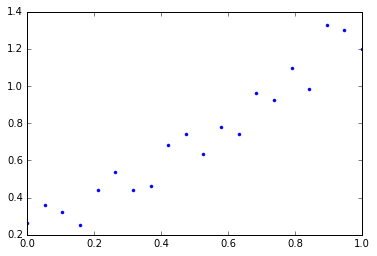

In [6]:
plt.plot(x, y, marker='.', linestyle='none')

In [7]:
# Plot fit
N2 = 2
new_x =  np.linspace(0, 1, N2).reshape((-1, 1))
new_X = np.column_stack([np.ones(N2).reshape((-1, 1)), new_x])

In [8]:
data = {
    'N': N,
    'X': X,
    'K': X.shape[1],
    'y': y.flatten(), 
    'N2': N2,
    'new_X': new_X
}

In [9]:
res = sm.optimizing(data=data)

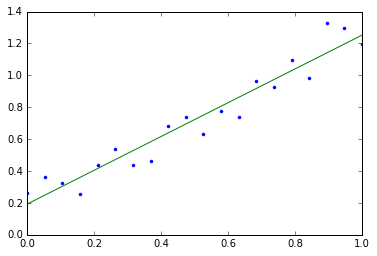

In [10]:
# Plot MLE fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(new_x, res['y_pred'])
plt.show()

In [11]:
res_vb = sm.vb(data=data, pars=['beta', 'y_pred'])
out_file = res_vb['args']['sample_file']
df = pd.read_csv(out_file, comment='#').iloc[2:, :]

In [12]:
df.describe()

,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,linpred.7,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.207894,1.073972,0.079215,0.207894,0.264419,0.320944,0.377469,0.433994,0.490518,0.547043,...,0.886192,0.942717,0.999242,1.055767,1.112292,1.168817,1.225342,1.281866,0.207894,1.281866
std,0.023548,0.046970,0.014910,0.023548,0.023446,0.023603,0.024016,0.024671,0.025549,0.026628,...,0.036106,0.038020,0.039995,0.042023,0.044096,0.046209,0.048355,0.050532,0.023548,0.050532
min,0.132571,0.923903,0.031374,0.132571,0.190082,0.247593,0.305104,0.359861,0.410052,0.460244,...,0.761395,0.811587,0.861778,0.911021,0.959647,1.008270,1.056900,1.105530,0.132571,1.105530
25%,0.193007,1.042730,0.069456,0.193007,0.249536,0.305524,0.361269,0.416772,0.473088,0.528436,...,0.863177,0.918798,0.973691,1.028980,1.084070,1.139430,1.194270,1.248730,0.193007,1.248730
50%,0.208485,1.074120,0.079024,0.208485,0.264889,0.321378,0.377856,0.434199,0.491038,0.547894,...,0.885205,0.941790,0.997802,1.054080,1.110500,1.166750,1.223680,1.280400,0.208485,1.280400
75%,0.223817,1.103440,0.089702,0.223817,0.280206,0.336952,0.393618,0.450212,0.507052,0.564666,...,0.910054,0.967947,1.025950,1.083320,1.140780,1.198820,1.257250,1.315480,0.223817,1.315480
max,0.277579,1.224080,0.119861,0.277579,0.330976,0.384707,0.442824,0.500941,0.560235,0.619920,...,0.984681,1.047890,1.111310,1.175740,1.240160,1.304590,1.369010,1.433440,0.277579,1.433440


In [13]:
df.head()

,lp__,beta.1,beta.2,sigma,linpred.1,linpred.2,linpred.3,linpred.4,linpred.5,linpred.6,...,linpred.13,linpred.14,linpred.15,linpred.16,linpred.17,linpred.18,linpred.19,linpred.20,y_pred.1,y_pred.2
2,0,0.207888,1.07498,0.079780,0.207888,0.264466,0.321043,0.377621,0.434199,0.490777,...,0.886821,0.943399,0.999977,1.05655,1.11313,1.16971,1.22629,1.28287,0.207888,1.28287
3,0,0.220605,1.06111,0.081609,0.220605,0.276453,0.332300,0.388148,0.443996,0.499844,...,0.890778,0.946625,1.002470,1.05832,1.11417,1.17002,1.22586,1.28171,0.220605,1.28171
4,0,0.179469,1.03960,0.083465,0.179469,0.234185,0.288901,0.343617,0.398333,0.453049,...,0.836061,0.890777,0.945493,1.00021,1.05493,1.10964,1.16436,1.21907,0.179469,1.21907
5,0,0.180455,1.06098,0.091318,0.180455,0.236295,0.292136,0.347977,0.403818,0.459659,...,0.850544,0.906385,0.962226,1.01807,1.07391,1.12975,1.18559,1.24143,0.180455,1.24143
6,0,0.209255,1.17483,0.075232,0.209255,0.271088,0.332921,0.394754,0.456588,0.518421,...,0.951254,1.013090,1.074920,1.13675,1.19859,1.26042,1.32225,1.38409,0.209255,1.38409


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbaa069f590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbaa045a950>]], dtype=object)

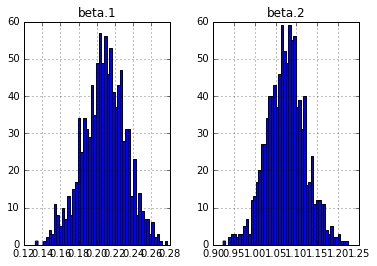

In [14]:
df[['beta.1', 'beta.2']].hist(bins=50)

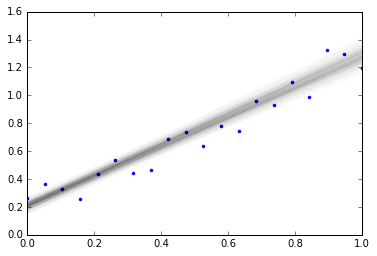

In [30]:
# Plot with generated values after Variational Bayes fit
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(np.tile(new_x, (1, len(df))), df[['y_pred.1', 'y_pred.2']].T.values, alpha=0.005, c='k')
plt.show()